In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import plotly.graph_objects as go
import plotly.express as px

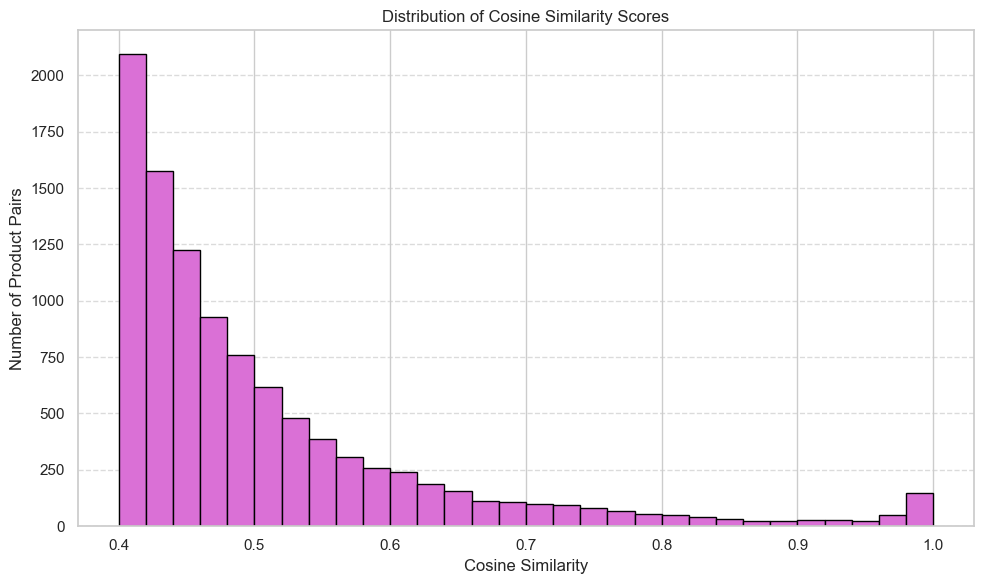

In [44]:
# load csv
df = pd.read_csv("similarities.csv")

# plot distribution of cosine similarity scores
plt.figure(figsize=(10, 6))
plt.hist(df['similarity'], bins=30, color='orchid', edgecolor='black')
plt.title('Distribution of Cosine Similarity Scores')
plt.xlabel('Cosine Similarity')
plt.ylabel('Number of Product Pairs')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:
# load data
top5_df = pd.read_csv("similarities.csv")
products_df = pd.read_csv("products.csv")

# merge category info
merged = top5_df.merge(products_df[['product_id', 'product_category']],
                       left_on='product_id_1', right_on='product_id', how='left') \
                .rename(columns={'product_category': 'category_1'}).drop(columns='product_id')

merged = merged.merge(products_df[['product_id', 'product_category']],
                      left_on='product_id_2', right_on='product_id', how='left') \
               .rename(columns={'product_category': 'category_2'}).drop(columns='product_id')

# keep pairs from the same category
merged = merged[merged['category_1'] == merged['category_2']]
merged = merged.dropna(subset=['category_1'])

# group by category and get stats
summary = []

for category, group in merged.groupby('category_1'):
    scores = group['similarity']
    stats = {
        'category': category,
        'count': len(scores),
        'mean': scores.mean(),
        'median': scores.median(),
        'min': scores.min(),
        'max': scores.max(),
        '25th_percentile': scores.quantile(0.25),
        '75th_percentile': scores.quantile(0.75),
        '90th_percentile': scores.quantile(0.90)
    }
    summary.append(stats)

# convert results to dataframe
summary_df = pd.DataFrame(summary).sort_values(by='mean', ascending=False)

print(summary_df.to_string(index=False))


              category  count     mean  median    min    max  25th_percentile  75th_percentile  90th_percentile
       High Tech Tools     37 0.681711 0.60920 0.4061 1.0000         0.510500         0.878800          0.93140
          Self Tanners    134 0.615863 0.58560 0.4035 0.9923         0.457650         0.764900          0.84603
             Sunscreen     72 0.586781 0.49975 0.4004 1.0000         0.433700         0.664350          0.98059
                 Masks    111 0.575574 0.50940 0.4009 1.0000         0.447500         0.652600          0.87260
              Wellness     26 0.519108 0.44880 0.4020 1.0000         0.420825         0.484550          0.85350
          Moisturizers    963 0.517280 0.45980 0.4000 1.0000         0.425700         0.538600          0.69890
     Value & Gift Sets    392 0.517206 0.45695 0.4002 1.0000         0.421950         0.575700          0.74089
Lip Balms & Treatments     55 0.503805 0.46480 0.4003 0.9422         0.414550         0.531000          

In [ ]:
# Load the data
products = pd.read_csv("products.csv")
similarities = pd.read_csv("similarities.csv")

# filter for similarities >= 0.9
threshold = 0.9
filtered = similarities[similarities['similarity'] >= threshold]

# mao product ID to product name
product_names = dict(zip(products['product_id'], products['product_name']))

# create a graph with only connected nodes
G = nx.Graph()

# add edges and nodes
for _, row in filtered.iterrows():
    pid1 = row['product_id_1']
    pid2 = row['product_id_2']
    G.add_edge(pid1, pid2, weight=row['similarity'])

# update node labels only for nodes that are in the graph
for node in G.nodes():
    G.nodes[node]['label'] = product_names.get(node, node)

# layout
pos = nx.spring_layout(G, k=1.5, iterations=50)

# extract node data
x_nodes = [pos[node][0] for node in G.nodes()]
y_nodes = [pos[node][1] for node in G.nodes()]
node_text = [G.nodes[node]['label'] for node in G.nodes()]

# extract edge data
x_edges, y_edges = [], []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]

# create edge trace
edge_trace = go.Scatter(
    x=x_edges, y=y_edges,
    line=dict(width=1.5, color='#888'),
    hoverinfo='none',
    mode='lines'
)

# create node trace with smaller font
node_trace = go.Scatter(
    x=x_nodes, y=y_nodes,
    mode='markers+text',
    hoverinfo='text',
    textposition="top right",
    textfont=dict(size=5), 
    marker=dict(
        showscale=False,
        color='lightblue',
        size=10,
        line_width=2
    ),
    text=node_text
)

# build figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title=dict(
                        text='Skincare Product Cosine Similarity Network Graph (≥ 90%)',
                        font=dict(size=16)
                    ),
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)
                )
)

fig.show()


In [ ]:
# load csvs
products = pd.read_csv("products.csv")
similarities = pd.read_csv("similarities.csv")

# filter for similarities ≥ 0.9
threshold = 0.9
filtered = similarities[similarities['similarity'] >= threshold]

# build graph
G = nx.Graph()
for _, row in filtered.iterrows():
    pid1, pid2 = row['product_id_1'], row['product_id_2']
    G.add_edge(pid1, pid2, weight=row['similarity'])

# add category info
product_name_map = dict(zip(products['product_id'], products['product_name']))
product_category_map = dict(zip(products['product_id'], products['product_category']))
for node in G.nodes():
    G.nodes[node]['category'] = product_category_map.get(node, 'Unknown')

# assign colors
unique_categories = sorted(set(nx.get_node_attributes(G, 'category').values()))
color_palette = px.colors.qualitative.Set3
category_color_map = {cat: color_palette[i % len(color_palette)] for i, cat in enumerate(unique_categories)}

# group nodes by category
category_traces = []
category_positions = {}
x_offset = 0
for i, category in enumerate(unique_categories):
    nodes_in_cat = [n for n in G.nodes() if G.nodes[n]['category'] == category]
    subgraph = G.subgraph(nodes_in_cat)
    local_pos = nx.spring_layout(subgraph, seed=42)
    for node, (x, y) in local_pos.items():
        category_positions[node] = (x + x_offset, y)
    x_offset += 3  # space between categories

pos = category_positions

for category in unique_categories:
    x_nodes, y_nodes, node_labels = [], [], []
    for node in G.nodes():
        if G.nodes[node]['category'] == category:
            x_nodes.append(pos[node][0])
            y_nodes.append(pos[node][1])
            node_labels.append(product_name_map.get(node, node))

    trace = go.Scatter(
        x=x_nodes,
        y=y_nodes,
        mode='markers',
        name=category,
        marker=dict(color=category_color_map[category], size=10, line_width=1),
        text=node_labels,
        hoverinfo='text'
    )
    category_traces.append(trace)

# edges
x_edges, y_edges = [], []
for edge in G.edges():
    x_edges += [pos[edge[0]][0], pos[edge[1]][0], None]
    y_edges += [pos[edge[0]][1], pos[edge[1]][1], None]

edge_trace = go.Scatter(
    x=x_edges, y=y_edges,
    line=dict(width=0.5, color='gray'),
    hoverinfo='none',
    mode='lines',
    showlegend=False
)

# plot
fig = go.Figure(data=[edge_trace] + category_traces,
                layout=go.Layout(
                    title=dict(
                        text='Skincare Product Cosine Similarity Scores Network Graph (≥ 90%)',
                        font=dict(size=16)
                    ),
                    showlegend=True,
                    legend_title=dict(text='Product Types'),
                    hovermode='closest',
                    margin=dict(b=20, l=5, r=5, t=40),
                    xaxis=dict(showgrid=False, zeroline=False, visible=False),
                    yaxis=dict(showgrid=False, zeroline=False, visible=False)
                )
)

fig.show()
